這份程式是為了輔助說明李宏毅教授《生成式人工智慧及機器學習導論》第三講的觀念，目的是透過執行此程式，讓學生更清楚理解大型語言模型內部的類神經網路如何運作。在開始執行之前，請先點選上方工具列的「檔案」，選擇「在雲端硬碟中儲存副本」，再於自己的副本中進行操作。

In [ ]:
!pip install -U transformers #安裝 HuggingFace Transformers 套件

以下程式碼將登入 Hugging Face Hub，以便接下來取得模型。但在此之前，我們需先取得 Hugging Face 的「Token」（此處的 Token 指的是認證憑證，與生成式 AI 中的 token 無關）。有關 Hugging Face Token 的取得與使用方式，請參閱作業一助教投影片：https://speech.ee.ntu.edu.tw/~hylee/GenAI-ML/2025-fall-course-data/hw1.pdf

In [1]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

load_dotenv()  # 读取 .env 文件
token = os.getenv("HUGGINGFACE_HUB_TOKEN")
login(token=token, new_session=False)

我們將下載位於此頁面的模型：https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct

如果你之前沒有使用過這個模型，在上述頁面中你可能會看到一行提示：「You need to agree to share your contact information to access this model」。這是因為使用 Llama 模型需要先簽署使用者同意書（並不是每個模型都需要簽署同意書）。請依照該頁面上的指示完成簽署，之後你會收到一封通知信，告知審查是否通過，通過後才能開始使用。這個過程有時可能需要數個小時。詳情請參閱助教投影片。

執行以下程式碼後，我們會從 Hugging Face Hub 下載 tokenizer 和 model 兩個物件。tokenizer 紀錄了模型所使用的 token，而 model 則儲存了模型的參數。下載過程可能需要數分鐘，請耐心等候。

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
#如果是 Colab 的免費使用者，可能會無法載入 3B 模型，這個時候可以把 3B 換成 1B

我們另外下載位於此頁面的模型: https://huggingface.co/google/gemma-3-4b-it

In [3]:
tokenizer2 = AutoTokenizer.from_pretrained("google/gemma-3-4b-it")
model2 = AutoModelForCausalLM.from_pretrained("google/gemma-3-4b-it")
#如果是 Colab 的免費使用者，可能會無法跑第二的模型, 這時請將這個 block 直接註解掉

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 我們來看看 model 中有什麼

我們先來看看我們載入的模型總共有幾個參數。model是Llama-3.2-3B-Instruct，model2是google/gemma-3-4b-it

``model.num_parameters()`` 會告訴我們 ``model`` 的參數量

In [ ]:
model.num_parameters() #我們來看看 model (meta-llama/Llama-3.2-3B-Instruct) 的參數量

3212749824

In [7]:
model2.num_parameters() #我們來看看 model2 (google/gemma-3-4b-it) 的參數量

4300079472

深度學習模型的參數通常以多個矩陣（Matrix）和向量（Vector）的形式儲存（向量、矩陣等統稱為張量（Tensor））。  

在模型中，每個包含參數的張量在 `model` 中具有以下資訊：  

- **名稱（name）**：表示該參數在模型結構中的位置，例如 `model.layers.0.mlp.up_proj.weight`，這是第一個 transformer layer 中第一層 MLP 的參數。  
- **形狀（shape）**：表示該張量的維度，例如 `(8192, 3072)`，代表這是一個矩陣，其中一維為 8192，另一維為 3072。  

我們可以用 `named_parameters()` 方法來逐一查看這些參數。


In [ ]:
for name, param in model.named_parameters():
    print(f"{name:80}  |  shape: {tuple(param.shape)}")

# 根據輸出，Llama-3.2-3B-Instruct 有幾層呢？
# Grouped-Query Attention (GQA)

model.embed_tokens.weight                                                         |  shape: (128256, 3072)
model.layers.0.self_attn.q_proj.weight                                            |  shape: (3072, 3072)
model.layers.0.self_attn.k_proj.weight                                            |  shape: (1024, 3072)
model.layers.0.self_attn.v_proj.weight                                            |  shape: (1024, 3072)
model.layers.0.self_attn.o_proj.weight                                            |  shape: (3072, 3072)
model.layers.0.mlp.gate_proj.weight                                               |  shape: (8192, 3072)
model.layers.0.mlp.up_proj.weight                                                 |  shape: (8192, 3072)
model.layers.0.mlp.down_proj.weight                                               |  shape: (3072, 8192)
model.layers.0.input_layernorm.weight                                             |  shape: (3072,)
model.layers.0.post_attention_layernorm.weight            

In [8]:
for name, param in model2.named_parameters():
    print(f"{name:80}  |  shape: {tuple(param.shape)}")

#比較看看，model (Llama-3.2-3B-Instruct) 和 model 2 (google/gemma-3-4b-it) 有什麼不同？

model.vision_tower.vision_model.embeddings.patch_embedding.weight                 |  shape: (1152, 3, 14, 14)
model.vision_tower.vision_model.embeddings.patch_embedding.bias                   |  shape: (1152,)
model.vision_tower.vision_model.embeddings.position_embedding.weight              |  shape: (4096, 1152)
model.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight               |  shape: (1152,)
model.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias                 |  shape: (1152,)
model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight          |  shape: (1152, 1152)
model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias            |  shape: (1152,)
model.vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight          |  shape: (1152, 1152)
model.vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias            |  shape: (1152,)
model.vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight   

用 `model.state_dict()` 可以實際把參數拿出來看看

In [ ]:
model.state_dict()

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 1.1292e-02,  9.9487e-03,  1.4160e-02,  ..., -3.5706e-03,
                       -1.9775e-02,  5.3711e-03],
                      [ 1.3245e-02, -3.8385e-05,  2.2461e-02,  ..., -2.6550e-03,
                        3.1738e-02, -1.0681e-03],
                      [ 1.9775e-02,  2.0020e-02,  2.8687e-02,  ..., -3.5248e-03,
                        3.1433e-03, -7.6294e-03],
                      ...,
                      [-3.0975e-03,  2.1057e-03,  4.8828e-03,  ..., -2.0905e-03,
                       -1.2207e-03, -2.8992e-03],
                      [-3.0975e-03,  2.1057e-03,  4.8828e-03,  ..., -2.0905e-03,
                       -1.2207e-03, -2.8992e-03],
                      [-3.0975e-03,  2.1057e-03,  4.8828e-03,  ..., -2.0905e-03,
                       -1.2207e-03, -2.8992e-03]])),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[-0.0327,  0.0297,  0.0645,  ...,  0.0835, -0.0356, -0.0197],
 

[[-0.01361084 -0.04003906  0.01977539 ...  0.02197266 -0.00186157
   0.01782227]
 [-0.02233887 -0.00927734 -0.0100708  ... -0.00112152  0.02392578
  -0.03149414]
 [ 0.01177979  0.01953125 -0.01135254 ...  0.00830078  0.01123047
   0.0222168 ]
 ...
 [ 0.04052734  0.02758789 -0.00708008 ...  0.02209473  0.00053024
  -0.02124023]
 [ 0.00256348 -0.01104736 -0.03173828 ...  0.00680542 -0.00952148
   0.00187683]
 [-0.00830078  0.02722168  0.00230408 ... -0.02453613  0.00457764
  -0.04492188]]


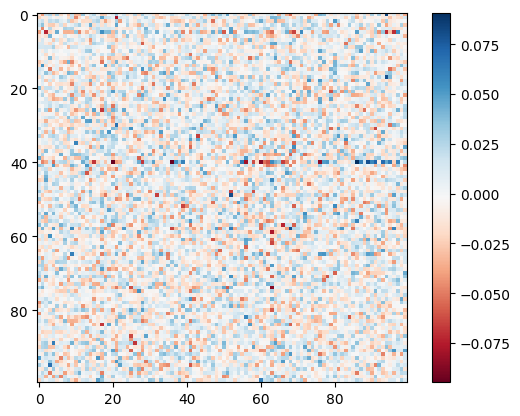

In [ ]:
weight = model.state_dict()["model.layers.27.mlp.up_proj.weight"].numpy()

#上面這段程式碼可以分成三個步驟來看：1. state_dict() 2. ["參數名稱"] 3. .numpy()
# model.state_dict() 方法會回傳一個字典（dict），其鍵（key）為參數名稱，值（value）為張量（Tensor）。
# 可以使用 [] 根據 key 取得對應的 value。
# 這裡的 value 是一個 PyTorch Tensor，.numpy() 會把 Tensor 轉成 NumPy 格式的陣列

print(weight)

#把 weight 中前100×100區塊畫出來
plt.imshow(weight[:100, :100], cmap="RdBu")
plt.colorbar()
plt.show()

#其實看不出甚麼名堂，對吧 ....

## 觀察語言模型中的 Embedding Table

In [10]:
#先取出model中的 embedding table

input_embedding = model2.state_dict()["model.language_model.embed_tokens.weight"].numpy()

先來看看 input_embedding 的形狀（shape）。

In [11]:
'''
把 input_embedding 的 shape 輸出出來觀察看看

你會看到 `(128256, 3072)`，表示 `input_embedding` 是一個具有 128,256 列（row）和 3,072 行（column）的矩陣。

- **128256** → 詞彙表（vocabulary）的大小，共有 128,256 個不同的 token。
- **3072** → 每個 token 以一個 3,072 維度的向量表示。

換句話說，每一列（row）對應到一個 token。
'''

print(input_embedding.shape)

(262208, 2560)


In [12]:
#把 input_embedding 輸出出來觀察看看
print(input_embedding)

#嗯 ... 其實還是看不出甚麼名堂

[[ 1.07421875e-02  2.05993652e-03 -2.30407715e-03 ... -8.66699219e-03
   1.86920166e-03 -8.05664062e-03]
 [-2.58789062e-02  3.11279297e-03  5.76782227e-03 ... -1.04370117e-02
  -7.99560547e-03  4.24194336e-03]
 [ 3.38745117e-03 -2.25830078e-03 -1.09863281e-03 ... -1.75476074e-03
  -2.82287598e-03  1.13677979e-03]
 ...
 [ 7.67707825e-05  3.33786011e-05 -2.88486481e-05 ...  4.79221344e-05
  -2.96831131e-05 -7.86781311e-05]
 [ 1.11103058e-04  3.43322754e-05  9.89437103e-06 ... -3.11434269e-06
  -1.13964081e-04 -1.30653381e-04]
 [ 4.24385071e-05 -5.62667847e-05  8.24928284e-05 ... -4.60147858e-05
  -1.30653381e-04 -1.52587891e-04]]


In [17]:
#編號為 `token_id` 的 token，其對應的 embedding 就是 `input_embedding` 的第 `token_id` 個列（row）（從 0 開始計數）。
#以下輸出編號為 `token_id` 的 token 以及其對應的 embedding。

token_id = 15644

# 從 tokenizer 取得對應 token_id 的 token（文字）
token = tokenizer2.decode(token_id)

# 取得該 token 的向量
embedding_vector = input_embedding[token_id]

print(f"Token ID: {token_id}")
print(f"對應的 Token: {token}")
print(f"Token Embedding: {embedding_vector}")

Token ID: 15644
對應的 Token:  advantages
Token Embedding: [ 0.02087402  0.02514648  0.01818848 ...  0.03588867 -0.00267029
 -0.01391602]


直接觀察 embedding 的數值其實看不出太多資訊，但我們可以計算 token 之間的 embedding 相似程度
這樣就能知道對於這個語言模型來說，哪些 token 的意義是相似的。
這段程式是要讓我們：
1. 輸入一個 token（例如 `"apple"`）  
2. 找到它的 `token_id` （例如 `"apple"`）
3. 根據 `token_id` 從 `input_embedding` 中取得它的 embedding  
4. 使用 cosine similarity 計算它與其他所有 token 的 embedding 相似程度  
5. 列出最相近的前 `top_k` 個 token

In [ ]:
top_k = 20 #自己設定一個數值

# 1️⃣ 讓使用者輸入一個 token
token = input('請輸入一個 token：') #輸入: apple, Apple, 李, 王 等等

# 2️⃣ 轉換成 token ID
token_id = tokenizer2.encode(token)[1]
# 為什麼是 [1]？
# tokenizer.encode() 回傳的是: [BOS_token_id, token_id ...]
# print (tokenizer.encode(token)) <- 跑這一行試試看
# 第一個元素 [0] 是特殊起始符號 (BOS)，
# 我們真正想要的是輸入的那個 token 本身 → 所以取 index 1
print("token id 是 ",token_id)

# 3️⃣ 取得 token 的 embedding
embbeding = [input_embedding[token_id]]

# 4️⃣ 計算餘弦相似度
sims = cosine_similarity(embbeding, input_embedding)[0]

# 5️⃣ 排序並取最相近 top_k,並輸出結果
nearest = sims.argsort()[::-1][1: top_k+1] #排除自己本身
print(f'和 {token} 最相近的 {top_k} 個 token：')
for idx in nearest:
  print(f'{tokenizer2.decode(idx)} (score: {sims[idx]:.4f})')

token id 是  10732
和 small 最相近的 20 個 token：
 small (score: 0.8515)
Small (score: 0.8010)
 Small (score: 0.7674)
 SMALL (score: 0.7271)
SMALL (score: 0.7134)
 pequeñas (score: 0.6017)
 pequeños (score: 0.6007)
 pequeño (score: 0.5976)
 pequeña (score: 0.5912)
smaller (score: 0.5889)
 kleine (score: 0.5843)
 piccoli (score: 0.5695)
 pequeno (score: 0.5694)
小 (score: 0.5674)
 pequena (score: 0.5658)
 pequenos (score: 0.5657)
 küçük (score: 0.5655)
 piccole (score: 0.5650)
 pequenas (score: 0.5647)
 kleinen (score: 0.5605)


/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## 輸出每一層的 representation

把每一層的 representation 都取出來

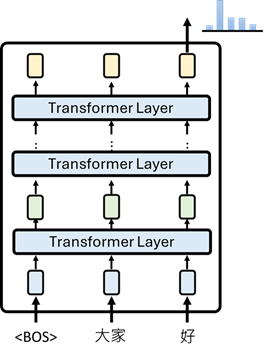

In [6]:
inputs = tokenizer2.encode("大家好", return_tensors="pt")
print("編碼後的 Token IDs：", inputs)

outputs = model2(inputs, output_hidden_states=True) # output_hidden_states=True 才會回傳每一層的 representation (hidden states)
hidden_states = outputs.hidden_states
# hidden_states[0] -> embedding （把 token 轉成 token embedding 的結果)
# hidden_states[1] ~ hidden_states[N] -> 每一層 Transformer block 的輸出
print(f"一共拿到 {len(hidden_states)} 層 representation（包含 token embedding）。")

# 列出每層輸出的形狀
for idx, h in enumerate(hidden_states):
    print(f"Layer {idx:2d} 輸出形狀: {h.shape}")
    # h.shape = [batch_size, seq_len, hidden_size]
    # batch_size → 一次處理的句子數
    # sequence_length → 句子被切成多少 token
    # hidden_size → 每個 token 的向量長度


print("\n=== Token Embedding 輸出 ===")
print(hidden_states[0])

print("\n=== 第一個 Transformer Layer 的輸出 ===")
print(hidden_states[1])

編碼後的 Token IDs： tensor([[    2, 58725]])
一共拿到 27 層 representation（包含 token embedding）。
Layer  0 輸出形狀: torch.Size([1, 2, 1152])
Layer  1 輸出形狀: torch.Size([1, 2, 1152])
Layer  2 輸出形狀: torch.Size([1, 2, 1152])
Layer  3 輸出形狀: torch.Size([1, 2, 1152])
Layer  4 輸出形狀: torch.Size([1, 2, 1152])
Layer  5 輸出形狀: torch.Size([1, 2, 1152])
Layer  6 輸出形狀: torch.Size([1, 2, 1152])
Layer  7 輸出形狀: torch.Size([1, 2, 1152])
Layer  8 輸出形狀: torch.Size([1, 2, 1152])
Layer  9 輸出形狀: torch.Size([1, 2, 1152])
Layer 10 輸出形狀: torch.Size([1, 2, 1152])
Layer 11 輸出形狀: torch.Size([1, 2, 1152])
Layer 12 輸出形狀: torch.Size([1, 2, 1152])
Layer 13 輸出形狀: torch.Size([1, 2, 1152])
Layer 14 輸出形狀: torch.Size([1, 2, 1152])
Layer 15 輸出形狀: torch.Size([1, 2, 1152])
Layer 16 輸出形狀: torch.Size([1, 2, 1152])
Layer 17 輸出形狀: torch.Size([1, 2, 1152])
Layer 18 輸出形狀: torch.Size([1, 2, 1152])
Layer 19 輸出形狀: torch.Size([1, 2, 1152])
Layer 20 輸出形狀: torch.Size([1, 2, 1152])
Layer 21 輸出形狀: torch.Size([1, 2, 1152])
Layer 22 輸出形狀: torch.Size([1, 2, 

讓我們來比較不同輸入的 representation

In [10]:
def get_embedding(text, layer_num):
    """
    輸入一句文字，印出模型某一個 layer 的每個 token 的 embedding。

    """
    print(f"\n=== {text} ===")

    inputs = tokenizer2.encode(text, return_tensors="pt", add_special_tokens=False)
    #print(inputs)

    outputs = model2(inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    hidden_states_layer = hidden_states[layer_num]

    tokens = tokenizer2.tokenize(text)
    seq_length = len(tokens)
    for t in range(0,seq_length):
      print(tokens[t], ":", hidden_states_layer[0][t])

layer_num = 1 # 0: token embedding, >0: contextualized token embedding
get_embedding("How about you?", layer_num )
get_embedding("How are you?", layer_num )
get_embedding("Nice to meet you.", layer_num )


=== How about you? ===
How : tensor([ 0.6652,  1.5122,  0.7605,  ..., -0.0406,  2.9621, -0.9286],
       grad_fn=<SelectBackward0>)
▁about : tensor([ 0.1330, -3.0248,  0.9207,  ...,  0.7730,  2.4174, -1.3765],
       grad_fn=<SelectBackward0>)
▁you : tensor([ 0.6852, -3.1402,  0.3629,  ...,  0.3000, -3.9661, -0.3427],
       grad_fn=<SelectBackward0>)
? : tensor([  1.3153,   0.5256,  -0.9663,  ...,  -0.0329, -11.5764,  -1.1053],
       grad_fn=<SelectBackward0>)

=== How are you? ===
How : tensor([ 0.6652,  1.5122,  0.7605,  ..., -0.0406,  2.9621, -0.9286],
       grad_fn=<SelectBackward0>)
▁are : tensor([  0.1203,  -1.0024,  -0.6226,  ...,  -0.1266, -10.8234,   0.1467],
       grad_fn=<SelectBackward0>)
▁you : tensor([ 0.6505, -2.3823,  0.4320,  ...,  0.3979, -4.6131, -0.4701],
       grad_fn=<SelectBackward0>)
? : tensor([  1.3987,   0.7028,  -0.8770,  ...,  -0.0635, -11.9941,  -0.9491],
       grad_fn=<SelectBackward0>)

=== Nice to meet you. ===
Nice : tensor([  0.8202,   0.5388, 

 apple
 apple


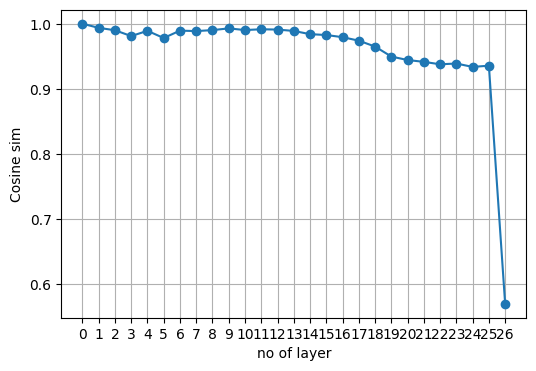

In [28]:
#比較 sentence1 和 sentence2 中的 "apple" ，在不同層的相似程度

sentence1 = "I ate an apple for breakfast."
idx1 = 4 # apple 在 "I ate an apple for breakfast." 的位置
print(tokenizer2.decode(tokenizer2.encode(sentence1)[4]))
#[128000, 40, 30912, 459, 24149, 369, 17954, 13]
sentence2 = "The company that brought us the iPad and AirPods is apple."
idx2 = 11 # apple 在 "The tech company apple announced its earnings yesterday." 的位置
print(tokenizer2.decode(tokenizer2.encode(sentence2)[11]))
#[128000, 791, 2883, 430, 7263, 603,  279, 23067, 323, 6690, 24434, 82,374,  24149, 13]

inputs1 = tokenizer2.encode(sentence1,return_tensors="pt")
outputs1 = model2(inputs1, output_hidden_states=True)
hidden_states1 = outputs1.hidden_states

inputs2 = tokenizer2.encode(sentence2,return_tensors="pt")
outputs2 = model2(inputs2, output_hidden_states=True)
hidden_states2 = outputs2.hidden_states

# 計算每一層的 cosine_similarity
distances = []
for l in range(len(hidden_states)):
    vec1 = hidden_states1[l][0][idx1].detach().numpy()  # 句子1 中 '▁apple' 的向量
    vec2 = hidden_states2[l][0][idx2].detach().numpy()  # 句子2 中 '▁apple' 的向量
    cos_sim = cosine_similarity([vec1], [vec2])[0]
    #print(cos_sim)
    distances.append(cos_sim)

# 繪製距離隨層數變化圖
layers = list(range(len(distances)))
plt.figure(figsize=(6, 4))
plt.plot(layers, distances, marker='o')
plt.xticks(layers)
plt.xlabel("no of layer")
plt.ylabel("Cosine sim")
plt.grid(True)
plt.show()

/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/durui/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero 

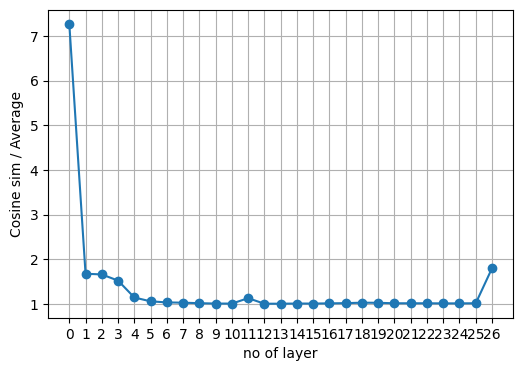

In [29]:
sentence1 = "I ate an apple for breakfast."
sentence2 = "The company that brought us the iPad and AirPods is apple."

inputs1 = tokenizer2.encode(sentence1, return_tensors="pt")
outputs1 = model2(inputs1, output_hidden_states=True)
hidden_states1 = outputs1.hidden_states

inputs2 = tokenizer2.encode(sentence2, return_tensors="pt")
outputs2 = model2(inputs2, output_hidden_states=True)
hidden_states2 = outputs2.hidden_states

distances = []
for l in range(len(hidden_states)):
    layer_hidden_states1 = hidden_states1[l][0].detach().numpy() # Shape: [seq_len1, hidden_size]
    layer_hidden_states2 = hidden_states2[l][0].detach().numpy() # Shape: [seq_len2, hidden_size]
    # Calculate pairwise cosine similarity between all tokens in sentence1 and sentence2 for this layer
    pairwise_sim = cosine_similarity(layer_hidden_states1, layer_hidden_states2) # Shape: [seq_len1, seq_len2]
    avg_sim_layer = pairwise_sim.mean()

    vec1 = hidden_states1[l][0][idx1].detach().numpy()  # 句子1 中 '▁apple' 的向量
    vec2 = hidden_states2[l][0][idx2].detach().numpy()  # 句子2 中 '▁apple' 的向量
    cos_sim = cosine_similarity([vec1], [vec2])[0]

    distances.append(cos_sim/avg_sim_layer)

# 繪製距離隨層數變化圖
layers = list(range(len(distances)))
plt.figure(figsize=(6, 4))
plt.plot(layers, distances, marker='o')
plt.xticks(layers)
plt.xlabel("no of layer")
plt.ylabel("Cosine sim / Average")
plt.grid(True)
plt.show()

 apple
 apple
 apple
 apple


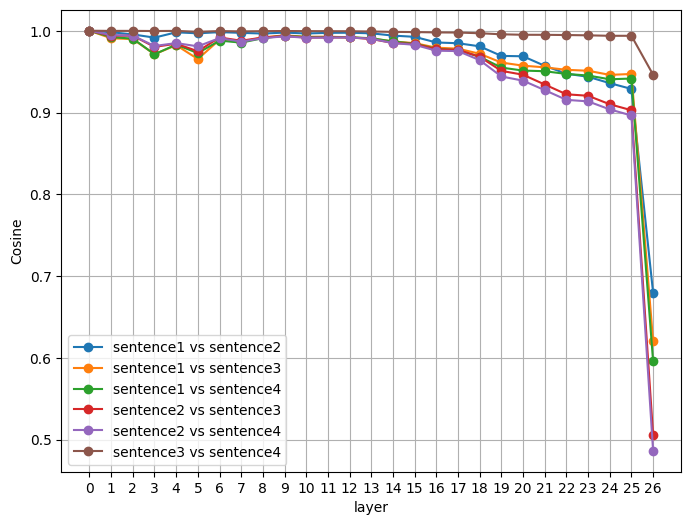

In [38]:
# 定義 4 個句子：前兩句是「可食用的 apple」，後兩句是「Apple 公司」
sentences = [
    "I ate an apple for breakfast.",                 # 可食用的 apple 範例 1
    "She baked an apple pie for dessert.",              # 可食用的 apple 範例 2
    "The tech giant apple announced its quarterly earnings.",    # Apple 公司範例 1
    "Last week the tech giant apple revealed its new iPhone."    # Apple 公司範例 2
]
num_sentences = 4

# 每句中 'apple' 的索引位置
idxs = [4,4,4,6]
for i, idx in enumerate(idxs):
    print(tokenizer2.decode(tokenizer2.encode(sentences[i])[idx]))

# 編碼並取得所有層的 hidden_states
hidden_states_batch = []
for i in range(num_sentences):
  inputs = tokenizer2.encode(sentences[i], return_tensors="pt")
  #print(inputs)
  outputs = model2(inputs, output_hidden_states=True)
  hidden_states_batch.append(outputs.hidden_states)

# 為每一對句子組合準備相似度儲存結構
pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
sim_dict = {pair: [] for pair in pairs}

# 逐層計算每對組合的 Cosine 相似度
num_layer = 27
for l in range(num_layer):
    for (i, j) in pairs:
        vec_i = hidden_states_batch[i][l][0][idxs[i]].detach().numpy()
        vec_j = hidden_states_batch[j][l][0][idxs[j]].detach().numpy()
        sim = cosine_similarity([vec_i], [vec_j])[0]
        sim_dict[(i, j)].append(sim)

# 繪製每對組合隨層數變化的相似度曲線
layers = list(range(len(hidden_states)))  # 0 = embedding 層
plt.figure(figsize=(8, 6))
for (i, j), sims in sim_dict.items():
    label = f"sentence{i+1} vs sentence{j+1}"
    plt.plot(layers, sims, marker='o', label=label)

plt.xticks(layers)
plt.xlabel("layer")
plt.ylabel("Cosine")
plt.legend()
plt.grid(True)
plt.show()

## 以 logit lens 解析 representation


在典型的語言模型使用中，輸入的 token 會經過多層 Transformer layer 的運算，每一層都會產生一組 representation。我們通常只取最後一層的表示，透過 Unembedding (LM head) 將其轉換到詞彙表大小的空間，得到每個 token 的 logit，最後再經由 softmax 得到下一個 token 的機率分布。換言之，我們平常只關注「最後的輸出層」。

Logit lens 的核心想法是：其實不一定要等到最後一層，我們可以在每一層的 representation 上套用相同的 Unembedding，來觀察如果「此時就直接拿來預測 token」，模型會認為最有可能的輸出是什麼。這樣做就像替每一層「戴上一副眼鏡」來觀察：模型在中間層時，腦中已經傾向哪些詞彙？隨著層數加深，模型又是如何逐步收斂到最終答案的呢？

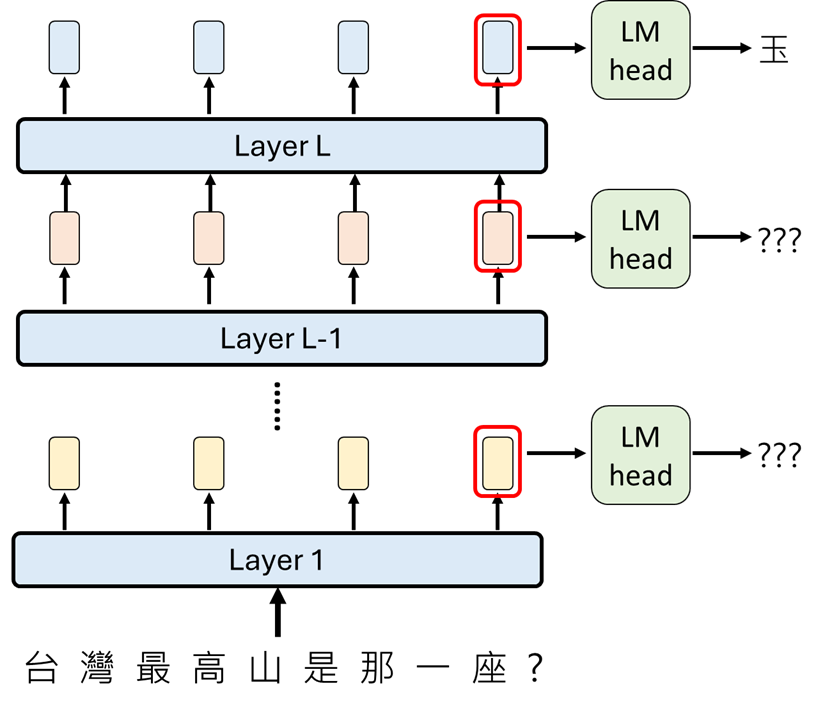

In [4]:
text = "珠穆朗玛" #天氣, 今天天氣真 ...

input_ids = tokenizer2.encode(text, return_tensors="pt")
outputs = model2(input_ids, output_hidden_states=True)
hidden_states = outputs.hidden_states  # 長度 = layer 數 + 1
print(f"一共拿到 {len(hidden_states)} 層 representation （包含 token embedding）。")

for l in range(len(hidden_states)):
    # 用該層 hidden state 經過 lm_head 得到 logits
    logits = model2.lm_head(hidden_states[l])   # [batch, seq_len, vocab_size]

    # 取最後一個 token 的 logits
    last_token_logits = logits[0, -1]  # [vocab_size]

    # 選分數最高的 token
    next_token_id = torch.argmax(last_token_logits)

    # 轉成字
    print(f"Layer {l:2d} → {tokenizer2.decode(next_token_id)}({next_token_id})")

一共拿到 35 層 representation （包含 token embedding）。
Layer  0 → 玛(241454)
Layer  1 → ꗜ(250251)
Layer  2 → ꗜ(250251)
Layer  3 → ꗜ(250251)
Layer  4 → ꗜ(250251)
Layer  5 → ꗜ(250251)
Layer  6 → ꗜ(250251)
Layer  7 → ꗜ(250251)
Layer  8 → ꗜ(250251)
Layer  9 → ꗜ(250251)
Layer 10 → ꗜ(250251)
Layer 11 → ꗜ(250251)
Layer 12 → ꗜ(250251)
Layer 13 → ꗜ(250251)
Layer 14 → ꗜ(250251)
Layer 15 → ꗜ(250251)
Layer 16 → ꗜ(250251)
Layer 17 → ꗜ(250251)
Layer 18 → ꗜ(250251)
Layer 19 → ꗜ(250251)
Layer 20 → ꗜ(250251)
Layer 21 → ꗜ(250251)
Layer 22 → ꗜ(250251)
Layer 23 → ꗜ(250251)
Layer 24 → ꗜ(250251)
Layer 25 → ꗜ(250251)
Layer 26 → ꗜ(250251)
Layer 27 → ꗜ(250251)
Layer 28 → ꗜ(250251)
Layer 29 → ꗜ(250251)
Layer 30 → ꗜ(250251)
Layer 31 → ꗜ(250251)
Layer 32 → ꗜ(250251)
Layer 33 → ꗜ(250251)
Layer 34 → 峰(239963)


## 觀察 Attention 在做甚麼

In [ ]:
#text  = "how are you"
text = "The apple is green. What color is the apple?"

tokens = tokenizer2.tokenize(text,add_special_tokens=True)
inputs = tokenizer2.encode(text, return_tensors="pt")
model2.config._attn_implementation = "eager"
#為什麼需要這個? 告訴模型請老老實實用普通 PyTorch 一步步算 attention，不要用快的方法，這樣 attentions 才會有內容。
outputs = model2(inputs, output_attentions=True)


'''
# 把上面幾行的 model -> model2, tokenizer ->　tokenizer2 ，就可以把 llama 換成 gemma 了
tokens = tokenizer2.tokenize(text,add_special_tokens=True)
inputs = tokenizer2.encode(text, return_tensors="pt")
model2.config._attn_implementation = "eager"
outputs = model2(inputs, output_attentions=True)
'''

attentions = outputs.attentions
print(f"總共有 {len(attentions)} 層")
for i, layer_attn in enumerate(attentions):
    print(f"Layer {i} attention shape: {layer_attn.shape}")

# 每一層的 attention 權重張量形狀都是 [1, 24, L, L]。
# 1 → batch_size (一次只輸入一段文字，所以 batch_size = 1)
# 24 → num_heads (這個每一層的 attention 有 24 组，每個 head 都有不同的「關注模式」，例如: 有的關注語法、有的關注語意。)
# L → seq_len（你的輸入句子，經過 tokenizer 之後被切成 L 個 token）
# 總之，每一層有 24 個大小為 L×L 的表格，每個格子是注意力權重（通常 0 ~ 1 之間，row方向加總 ≈ 1）

總共有 34 層
Layer 0 attention shape: torch.Size([1, 8, 12, 12])
Layer 1 attention shape: torch.Size([1, 8, 12, 12])
Layer 2 attention shape: torch.Size([1, 8, 12, 12])
Layer 3 attention shape: torch.Size([1, 8, 12, 12])
Layer 4 attention shape: torch.Size([1, 8, 12, 12])
Layer 5 attention shape: torch.Size([1, 8, 12, 12])
Layer 6 attention shape: torch.Size([1, 8, 12, 12])
Layer 7 attention shape: torch.Size([1, 8, 12, 12])
Layer 8 attention shape: torch.Size([1, 8, 12, 12])
Layer 9 attention shape: torch.Size([1, 8, 12, 12])
Layer 10 attention shape: torch.Size([1, 8, 12, 12])
Layer 11 attention shape: torch.Size([1, 8, 12, 12])
Layer 12 attention shape: torch.Size([1, 8, 12, 12])
Layer 13 attention shape: torch.Size([1, 8, 12, 12])
Layer 14 attention shape: torch.Size([1, 8, 12, 12])
Layer 15 attention shape: torch.Size([1, 8, 12, 12])
Layer 16 attention shape: torch.Size([1, 8, 12, 12])
Layer 17 attention shape: torch.Size([1, 8, 12, 12])
Layer 18 attention shape: torch.Size([1, 8, 12,

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.82807398e-01 1.71925575e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.43430114e-01 3.49349290e-01 7.22054252e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.80713272e-01 4.09103334e-01 1.14780234e-03 9.03564598e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.97918296e-01 6.45929351e-02 1.22844679e-02 1.06398106e-01
  1.18806146e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.18721169e-01 1.63929164e-01 9.53440368e-03 3.59944761e-01
  3

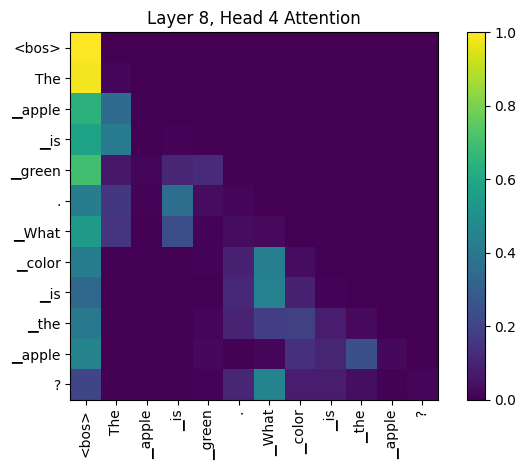

In [9]:
layer_idx = 7  #假設我們想觀察第 6 層 (layer_idx=5)
head_idx = 3  #假設我們想觀察第 7 個 Head (head_idx=6) 的注意力分佈 #可以把 6 改成其他數字，例如: 5,4,3

attn_matrix = attentions[layer_idx][0][head_idx].detach().numpy()
print(attn_matrix)

plt.imshow(attn_matrix, cmap="viridis")
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.title(f"Layer {layer_idx+1}, Head {head_idx+1} Attention")
plt.colorbar()
plt.tight_layout()
plt.show()

#你會看到一個 L X L 的矩陣，嘗試解讀你看到了什麼? 為什麼右上角都是0

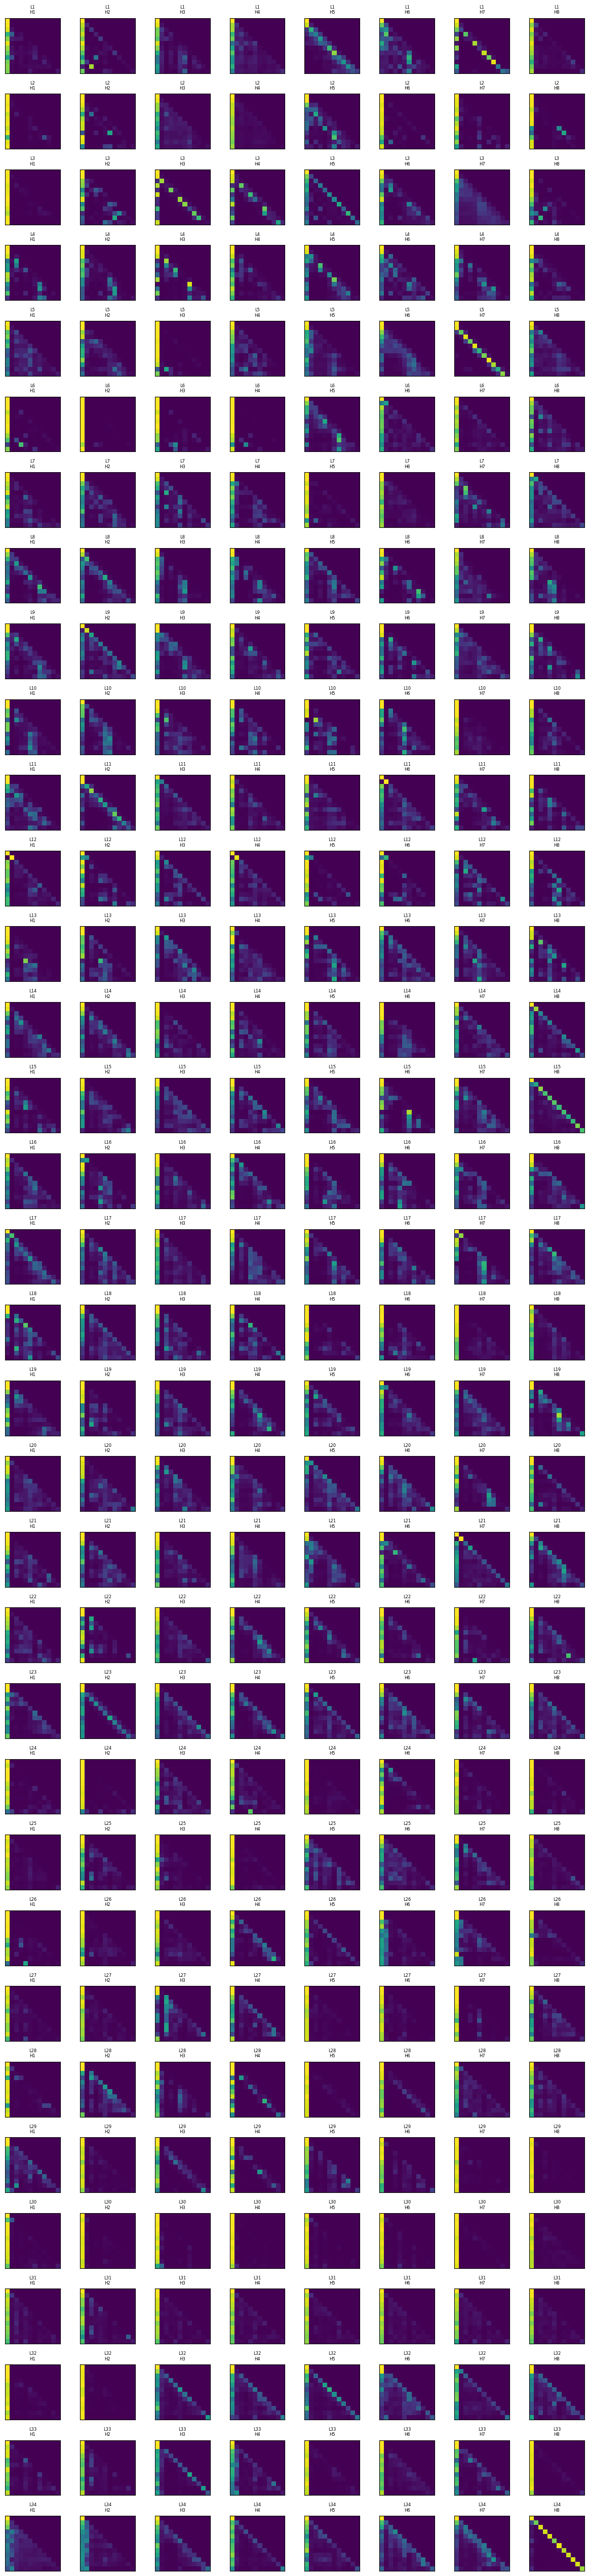

In [10]:
num_layers = len(attentions)
num_heads = attentions[0].shape[1]  # 每層 head 數

# 建立總圖
fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads*1.5, num_layers*1.5))
if num_layers == 1 and num_heads == 1:
    axes = [[axes]]
elif num_layers == 1:
    axes = [axes]
elif num_heads == 1:
    axes = [[ax] for ax in axes]

# 畫每個子圖
for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        ax = axes[layer_idx][head_idx]
        attn_matrix = attentions[layer_idx][0, head_idx].detach().cpu().numpy()
        ax.imshow(attn_matrix, cmap="viridis")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"L{layer_idx+1}\nH{head_idx+1}", fontsize=6)

#plt.suptitle("Attention Maps (Layer × Head)", fontsize=14)
plt.tight_layout()
plt.show()

試試看有沒有辦法把 gemma 的 attention 畫出來，看看有什麼不一樣？